In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# remove the SettingWithCopyWarning

pd.options.mode.chained_assignment = None

In [3]:
pg = "../data/07-clustered-graphs/alpha0.3_k10_res0.002.graphml"
G = nx.read_graphml(pg)
pdf = "../data/06-clustered-df/alpha0.3_k10_res0.002.pkl"
df = pd.read_pickle(pdf)

pcd = "../output/tables/cluster-explorer/SingleSolExplorer_alpha0.3_k10_res0.002.xlsx"
# first sheet is the cluster details
cluster_details = pd.read_excel(pcd, sheet_name=0)

# Prepare


In [4]:
def process_given_labels(summary_df, n_words=5):
    cols = [col for col in summary_df.columns if col.startswith("Word_")]
    word_cols = cols[:n_words]
    summary_df["Given Label"] = summary_df[word_cols].apply(
        lambda row: "; ".join(list(set(row.values))), axis=1
    )
    # add cluster number to the given label
    summary_df["Given Label"] = summary_df[["Cluster", "Given Label"]].apply(
        lambda row: f"{str(row['Cluster'])}: {row['Given Label']}", axis=1
    )
    # remove cols
    summary_df = summary_df.drop(columns=cols)
    return summary_df


summary_df = process_given_labels(cluster_details, n_words=3)
cluster_label_dict = dict(zip(summary_df["Cluster"], summary_df["Given Label"]))
summary_df.head(3)

,Cluster,Nr of Pubs,Mean Year,SD Year,Given Label
0,0,1199,2016.7,5.6,0: effects; fluoxetine; pharmaceuticals
1,1,1152,2001.9,8.7,1: fluoxetine; receptor; ht
2,2,1018,2003.7,9.4,2: fluoxetine; fluvoxamine; drug


# VISUALS


# Interactive visualization


In [5]:
class InteractiveProportionsPlotter:
    """
    A class to visualize cluster proportions over time using Plotly.
    """

    def __init__(
        self,
        df,
        cluster_label_dict,
        year_col="year",
        cluster_col="cluster_alpha0.3_k10_res0.002",
    ):
        self.df = df
        self.year_col = year_col
        self.cluster_col = cluster_col
        self.cluster_label_dict = cluster_label_dict

    def plot_proportions(
        self,
        cluster_subset_list,
        figsize=(10, 6),
        proportions_total="total",
        save=False,
    ):
        cluster_counts = (
            self.df.groupby([self.year_col, self.cluster_col])
            .size()
            .reset_index(name="count")
        )

        subset_cluster_counts = cluster_counts[
            cluster_counts[self.cluster_col].isin(cluster_subset_list)
        ]

        # Calculate yearly totals for normalization
        if proportions_total == "total":
            yearly_totals = cluster_counts.groupby(self.year_col)["count"].transform(
                "sum"
            )
            y_label = "Proportion of Total"
        elif proportions_total == "subset":
            yearly_totals = subset_cluster_counts.groupby(self.year_col)[
                "count"
            ].transform("sum")
            y_label = "Proportion of Subset Total"

        subset_cluster_counts["proportion"] = (
            subset_cluster_counts["count"] / yearly_totals
        )

        long_df = (
            subset_cluster_counts.pivot(
                index=self.year_col, columns=self.cluster_col, values="proportion"
            )
            .fillna(0)
            .reset_index()
            .melt(id_vars=[self.year_col], var_name="Cluster", value_name="Proportion")
        )

        long_df["Cluster"] = long_df["Cluster"].map(self.cluster_label_dict)

        fig = px.area(
            long_df,
            x=self.year_col,
            y="Proportion",
            color="Cluster",
            title="Cluster Proportions Over Time",
            labels={self.year_col: "Year", "Proportion": y_label},
            width=figsize[0] * 100,
            height=figsize[1] * 100,
        )

        fig.update_layout(
            dict(
                updatemenus=[
                    dict(
                        type="buttons",
                        direction="left",
                        buttons=list(
                            [
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle",
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle",
                                ),
                            ]
                        ),
                        pad={"r": 10, "t": 10},
                        showactive=False,
                        x=1,
                        xanchor="right",
                        y=1.1,
                        yanchor="top",
                    ),
                ]
            )
        )

        fig.show()
        if save == True:
            fig.write_html(
                "/Users/jlq293/Projects/Study-1-Bibliometrics/output/figures/cluster_proportions.html"
            )

In [6]:
# Example usage
plotter = InteractiveProportionsPlotter(
    df,
    cluster_label_dict=cluster_label_dict,
    year_col="year",
    cluster_col="cluster_alpha0.3_k10_res0.002",
)


plotter.plot_proportions(
    cluster_subset_list=list(range(len(df))),
    figsize=(15, 8),
    proportions_total="total",
    save=True,
)
plotter.plot_proportions(
    cluster_subset_list=list(range(10)), figsize=(15, 8), proportions_total="subset"
)

# StaticProportionsPlotter


In [7]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


class StaticProportionsPlotter:
    def __init__(
        self,
        df,
        cluster_label_dict,
        cluster_col="cluster",
        year_col="year",
        font_name="Arial",
        font_size=12,
    ):
        self.df = df
        self.cluster_label_dict = cluster_label_dict
        self.cluster_col = cluster_col
        self.year_col = year_col
        self.font_name = font_name
        self.font_size = font_size

    def _calculate_cluster_proportions_per_year(self):
        """
        This creates a df in long format with the counts of papers per cluster per year.
        """
        cluster_counts = (
            self.df.groupby([self.year_col, self.cluster_col])
            .size()
            .reset_index(name="count")
        )
        cluster_proportions = cluster_counts.groupby(self.year_col)["count"].transform(
            "sum"
        )

        cluster_counts["proportion"] = cluster_counts["count"] / cluster_proportions

        self.cluster_counts = cluster_counts

    def _calculate_subset_cluster_proportions_per_year(self, clusters_to_plot):
        """
        filters the cluster counts to only include the selected clusters and calculates the proportions. also calculates the total proportions for the selected subset. uses this as top y axis
        """
        # Calculate proportions for the selected subset
        filtered_cluster_counts = self.cluster_counts[
            self.cluster_counts[self.cluster_col].isin(clusters_to_plot)
        ]
        subset_proportions = filtered_cluster_counts.groupby(self.year_col)[
            "count"
        ].transform("sum")
        filtered_cluster_counts["proportion"] = (
            filtered_cluster_counts["count"] / subset_proportions
        )
        return filtered_cluster_counts

    def _set_x_axis_ticks_and_limits(self, ax, pivot_df):
        """
        Set x-axis ticks and limits based on the range of years in the DataFrame.
        """
        min_year = pivot_df.index.min()
        max_year = pivot_df.index.max()

        # Calculate the range of years to include ticks
        start_year = min_year - 1
        end_year = max_year + 1

        # Calculate the ticks every 5 years within the range
        years = np.arange(start_year, end_year, 5)

        # Ensure the min and max years are included in the ticks
        years = np.append(years, max_year)
        years = np.insert(years, 0, min_year)

        ax.set_xticks(years)

        # Set x-axis limits with a buffer of 0.2 years
        ax.set_xlim(min_year - 0.2, max_year + 0.2)

    def plot_cluster_proportions(
        self,
        clusters_to_plot: list,
        proportions_total="total",
    ):
        """
        Plots the cluster proportions over time. The total proportion can either be the overall total or the total of the selected subset.

        """
        if not hasattr(self, "cluster_counts"):
            self._calculate_cluster_proportions_per_year()

        if proportions_total == "total":
            # Use overall proportions
            filtered_cluster_counts = self.cluster_counts.copy()
            yaxis_label = "Proportion (Overall)"
        elif proportions_total == "subset":
            filtered_cluster_counts = (
                self._calculate_subset_cluster_proportions_per_year(clusters_to_plot)
            )
            yaxis_label = "Proportion (Subset)"

        pivot_df = filtered_cluster_counts.pivot(
            index=self.year_col, columns=self.cluster_col, values="proportion"
        ).fillna(0)

        # Plot only the selected clusters
        pivot_df = pivot_df[clusters_to_plot]

        # Extract labels for the clusters being plotted
        cluster_labels = [
            self.cluster_label_dict[cluster] for cluster in clusters_to_plot
        ]

        colors = plt.cm.tab20.colors[: len(clusters_to_plot)]

        # Create an area plot using Matplotlib
        fig, ax = plt.subplots(figsize=(15, 8))
        ax.stackplot(
            pivot_df.index, pivot_df.values.T, labels=cluster_labels, colors=colors
        )

        ax.set_ylabel(yaxis_label, fontsize=self.font_size, fontname=self.font_name)
        ax.set_title(
            "Cluster Proportions Over Time",
            fontsize=self.font_size,
            fontname=self.font_name,
        )
        ax.legend(
            title="Cluster",
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            fontsize=self.font_size,
            title_fontsize=self.font_size,
        )

        self._set_x_axis_ticks_and_limits(ax, pivot_df)

        # Set font for tick labels
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontname(self.font_name)
            label.set_fontsize(self.font_size)
        # plt.tight_layout()
        # plt.savefig("output.png", dpi=300)
        plt.show()


# Example usage
spp = StaticProportionsPlotter(
    df,
    cluster_label_dict,
    cluster_col="cluster_alpha0.3_k10_res0.002",
    font_name="Arial",
    font_size=12,
)

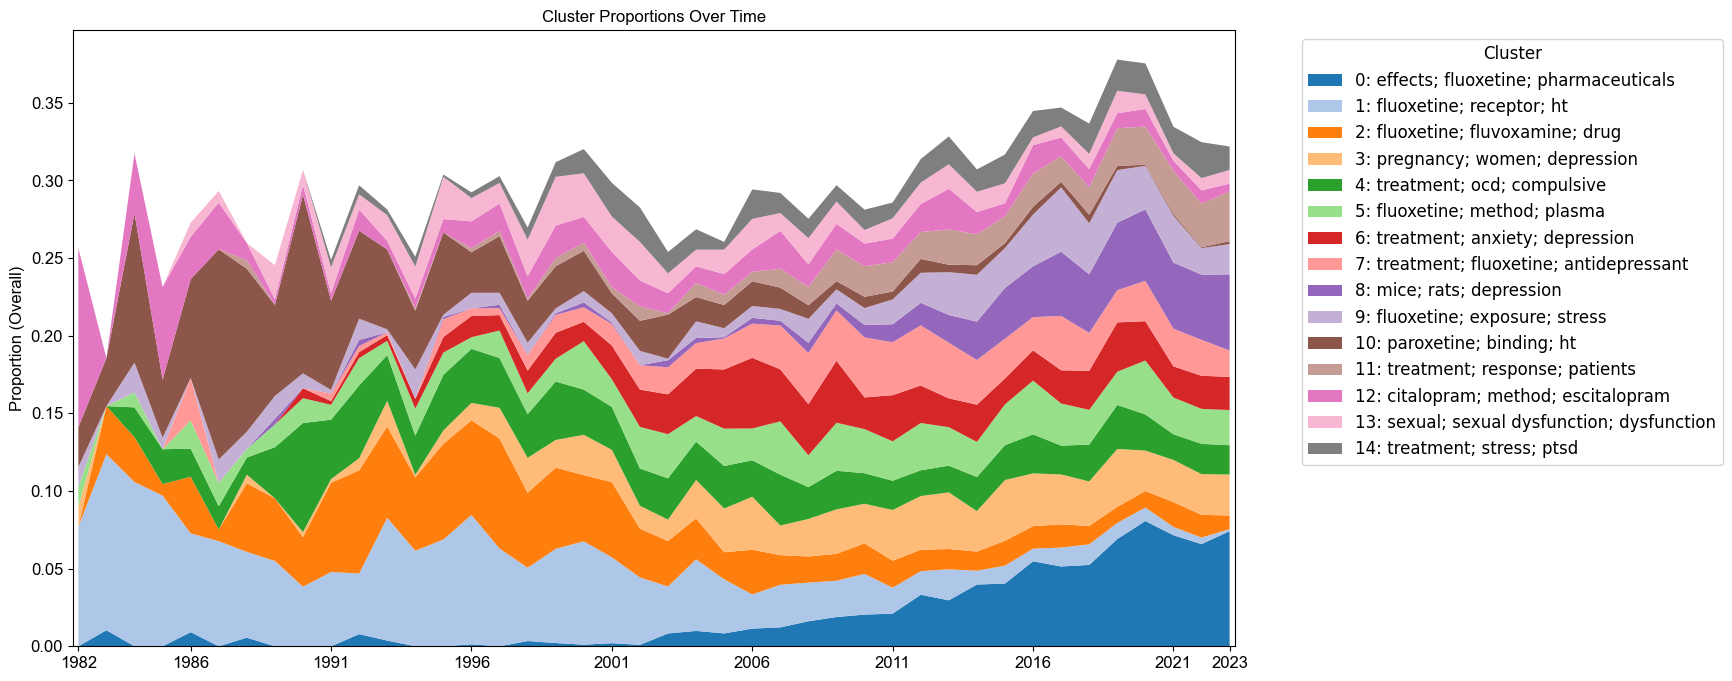

In [8]:
spp.plot_cluster_proportions(
    clusters_to_plot=list(range(0, 15)),
    proportions_total="total",
)